In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import urllib.request
import zipfile
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from datetime import datetime

In [ ]:
!wget --no-check-certificate \
    "https://github.com/ShreyaJaiswal1604/Detecting_Arthritis_X-Ray_Images/archive/refs/heads/main.zip" \
    -O "/tmp/Arthritis-dataset.zip"



zip_ref = zipfile.ZipFile('/tmp/Arthritis-dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-06-04 15:17:07--  https://github.com/ShreyaJaiswal1604/Detecting_Arthritis_X-Ray_Images/archive/refs/heads/main.zip
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ShreyaJaiswal1604/Detecting_Arthritis_X-Ray_Images/zip/refs/heads/main [following]
--2023-06-04 15:17:07--  https://codeload.github.com/ShreyaJaiswal1604/Detecting_Arthritis_X-Ray_Images/zip/refs/heads/main
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Arthritis-dataset.zip’

/tmp/Arthritis-data     [            <=>     ]  89.88M  38.1MB/s    in 2.4s    

2023-06-04 15:17:10 (38.1 MB/s) - ‘/tmp/Arthritis-dataset.zip’ saved [94250618]



In [ ]:
# Define dataset paths
base_dir = '/tmp/Detecting_Arthritis_X-Ray_Images-main/Image_Datasets/Original_Kaggle_Binary_Dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [ ]:
print("base_dir", base_dir)
print("train_dir", train_dir)
print("test_dir", test_dir)
print("val_dir", val_dir)

base_dir /tmp/Detecting_Arthritis_X-Ray_Images-main/Image_Datasets/Original_Kaggle_Binary_Dataset
train_dir /tmp/Detecting_Arthritis_X-Ray_Images-main/Image_Datasets/Original_Kaggle_Binary_Dataset/train
test_dir /tmp/Detecting_Arthritis_X-Ray_Images-main/Image_Datasets/Original_Kaggle_Binary_Dataset/test
val_dir /tmp/Detecting_Arthritis_X-Ray_Images-main/Image_Datasets/Original_Kaggle_Binary_Dataset/val


In [ ]:
# Define image data generators with data augmentation for training and normalization for validation/testing
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.1,    # Randomly shift images horizontally
    height_shift_range=0.1,   # Randomly shift images vertically
    shear_range=0.1,          # Apply shear transformation
    zoom_range=0.1,           # Apply zoom transformation
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill newly created pixels after rotation or shifting
)

In [ ]:
test_val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values to [0, 1]


In [ ]:
# Define batch size and image size
batch_size = 32
image_size = (224, 224)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 2459 images belonging to 2 classes.


In [ ]:
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 690 images belonging to 2 classes.


In [ ]:
val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 355 images belonging to 2 classes.


In [ ]:
# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    ),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2023-06-04 15:17:14.938731: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


---
**CODE EXPLANATION**

---
The given code defines the architecture of a model using the Keras Sequential API. Here's an explanation of each component:

tf.keras.applications.DenseNet201: This is a pre-trained DenseNet201 model provided by Keras. By setting include_top=False, we exclude the fully connected layers at the top of the network. This allows us to use the pre-trained convolutional base layers for feature extraction.

**weights='imagenet':** This parameter specifies that we want to use the pre-trained weights of the DenseNet201 model that were trained on the ImageNet dataset. These weights capture general image features and can be useful for transfer learning.

**input_shape=(224, 224, 3):** This defines the input shape of the model. In this case, the input shape is set to (224, 224, 3), indicating that the model expects input images of size 224x224 pixels with 3 color channels (RGB).

**tf.keras.layers.GlobalAveragePooling2D():** This layer performs global average pooling on the output of the pre-trained DenseNet201 model. It reduces the spatial dimensions of the feature maps to a vector by taking the average value across each feature map. This helps to extract a compact representation of the features.

**tf.keras.layers.Dense(1, activation='sigmoid'):** This is the final dense layer of the model with 1 neuron. It uses the sigmoid activation function, which maps the output to a range of [0, 1], representing the probability of the input belonging to the positive class. In this case, since it's a binary classification task (healthy or arthritis), we have a single output neuron.

By combining these layers in a sequential manner, we create a model architecture that takes an input image, passes it through the pre-trained DenseNet201 base, performs global average pooling, and finally passes the result through a dense layer with sigmoid activation to obtain the output prediction.

---

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model  
print("START TIME : ") 
start_ts = time.time()
print("----------------------------------------")     
                                          
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)
print("END TIME : ") 
end_ts = time.time()
print("----------------------------------------")  
# convert timestamps to datetime object
dt1 = datetime.fromtimestamp(start_ts)
print('Datetime Start:', dt1)
dt2 = datetime.fromtimestamp(end_ts)
print('Datetime End:', dt2)

# Difference between two timestamps
# in hours:minutes:seconds format
delta = dt2 - dt1
print("----------------------------------------")  
print('Difference is:', delta)
print("----------------------------------------")  

Epoch 1/5


2023-06-04 15:17:42.445607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9305 

2023-06-04 16:06:23.808050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 3006s 38s/step - loss: 0.1835 - accuracy: 0.9305 - val_loss: 1.9900 - val_accuracy: 0.9127
Epoch 2/5
77/77 [==============================] - 2936s 38s/step - loss: 0.0636 - accuracy: 0.9797 - val_loss: 0.3113 - val_accuracy: 0.9239
Epoch 4/5
77/77 [==============================] - 2932s 38s/step - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.0582 - val_accuracy: 0.9718
Epoch 5/5
77/77 [==============================] - 2944s 38s/step - loss: 0.0417 - accuracy: 0.9870 - val_loss: 0.0930 - val_accuracy: 0.9718


---
**EXPLANATION**

---
The given code is training the model using the fit method of the Keras Model class. Here's what each parameter does:

**train_generator:** It is the generator that yields batches of training data, consisting of input images and their corresponding labels. It is used to train the model on the training dataset.

**epochs:** It specifies the number of times the model will iterate over the entire training dataset during training. In this case, the model will be trained for 10 epochs.

**validation_data:** It is the generator that yields batches of validation data, used to evaluate the model's performance on a separate dataset during training. The validation data is used to monitor the model's progress and prevent overfitting.

During the training process, the model's weights and biases are updated iteratively to minimize the loss function defined in the model's compilation step. The fit method performs forward and backward propagation, calculates gradients, and updates the model parameters using an optimizer. The training process continues for the specified number of epochs, with the model gradually improving its performance on the training and validation data.


---
In the context of training a machine learning model, "epochs" refers to the number of times the model will iterate over the entire training dataset during the training process. Each epoch consists of going through the entire dataset once and updating the model's parameters based on the observed errors.

When you set epochs=10 in the code, it means that the model will undergo 10 complete passes over the training dataset. In each epoch, the model will make predictions on the training data, calculate the loss (error), and adjust its internal parameters (weights and biases) based on the gradient of the loss function. By repeating this process for multiple epochs, the model learns from the data and improves its ability to make accurate predictions.

The number of epochs is a hyperparameter that needs to be carefully chosen. **Too few epochs may result in underfitting, where the model fails to capture the underlying patterns in the data. On the other hand, too many epochs may lead to overfitting, where the model becomes overly specialized to the training data and performs poorly on unseen data. The optimal number of epochs can vary depending on the complexity of the problem and the size of the dataset, and it often requires experimentation and validation on a separate validation set.**

---






In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

2023-06-04 19:25:29.003387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 130s 6s/step - loss: 0.1331 - accuracy: 0.9623
Test Loss: 0.1331
Test Accuracy: 0.9623


In [ ]:
# Get the true labels for the test set
y_true = test_generator.classes

In [ ]:
# Make predictions on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob).flatten()

2023-06-04 19:50:43.032243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 130s 6s/step


In [ ]:
print(y_pred)

[0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [ ]:
# Generate confusion matrix


cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 25  26]
 [  0 639]]


NameError: name 'plt' is not defined

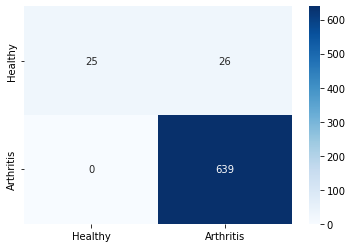

In [ ]:
# Display the confusion matrix


labels = ['Healthy', 'Arthritis']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

---
**REFERENCES**

---
https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

https://pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/